现有CNRDS获取并筛选的四个数据库（上市公司/其他股吧，交易时间/自然日），虽然前期基于单个帖子的LLM情感分析被数据库替代了，但我们完全可以基于这些**聚合后的统计数据**进行更宏观、更深入的情绪分析和挖掘，并尝试结合一些前沿的概念或方法来增加研究的亮点。
这是一个很好的机会，将**数据驱动的量化分析与对市场情绪的理解**结合起来。我们来制定一个渐进式深入的方案。

**核心思路：**
1. **数据整合与预处理**： 将四个数据集加载进来，*统一数据格式，特别是时间列*，并理解数据结构。
2. **情感指标构建**： 利用已有的正面/负面/中性帖子数量，构建更综合的*情感指数*。
3. **描述性统计与探索性分析 (EDA)**： 计算基本统计量，*初步可视化*，了解数据的整体分布和特征。
4. **时间序列分析与可视化**： 重点分析**情感指数、发帖量、阅读/评论数**等指标随**时间**的变化趋势，进行对比分析。
5. **关联性分析**： 探索情绪指标与黄金价格（需要外部数据）之间的相关性。

6. **（亮点拓展）引入前沿概念/方法**：
    - **注意力机制模拟**: 虽然不能直接用LLM分析原始文本，但可以模拟"注意力"概念，构建加权情感指数（考虑阅读数/评论数）。
    - **市场关注度分析**: 利用帖子总量、阅读数、评论数作为市场对黄金或特定公司关注度的代理指标。
    - **交易/非交易时段情绪差异**: 利用交易时间数据，分析开盘/盘中/收盘/非交易时段的情绪特征。
    - **（可选）简单的时序预测模型**: 尝试用历史情绪指标预测未来情绪波动（注意：预测价格风险大且可能不准确，但可以作为方法展示）。
    - **精美交互式可视化**: 使用 Plotly 等库创建可交互的图表。

**数据文件假设:**
假设你已经将这四个数据集分别保存为 CSV 文件：
- other_guba_trading_time.csv （其他股吧帖子统计（交易时间））
- other_guba_daily.csv （其他股吧帖子统计（自然日））
- company_guba_trading_time.csv （上市公司股吧帖子统计（交易时间））
- company_guba_daily.csv （上市公司股吧帖子统计（自然日））

**详细步骤与代码实现**

**第0步：环境设置与库安装**

- 操作: 确保必要的库已安装。这次我们主要用到数据处理和可视化库，可能还需要统计库。
- 代码:
```bash
pip install pandas numpy matplotlib seaborn statsmodels plotly kaleido # statsmodels 用于统计分析, plotly 用于交互式可视化, kaleido 用于导出plotly图像```
# 确保你的字体设置依然有效


**第1步：数据加载与预处理**
- **操作**: 加载四个CSV文件，统一列名（去除中括号和说明），转换日期格式，筛选所需时间范围（2020年7-10月，2022年2-5月）。
- **注释与依据**:
    - **加载所有必要库**，特别是 `plotly` 用于交互式可视化。
    - **统一列名**，去除说明文字，方便后续代码调用。特别修正了字段名不一致的问题。
    - **健壮的日期转换**：由于你的数据片段中日期格式不完全一致（`/` 和 `-`），代码尝试了多种常见格式，并加入了自动推断作为后备，以及错误处理，提高了代码的鲁棒性。
    - **时间段筛选**：根据你指定的研究时期（2020年7-10月，2022年2-5月）精确筛选数据，并为每个时期打上标签 (`Period`)，方便后续分组分析。
    - **使用 `.copy()`**：在**筛选和添加列**时使用 `.copy()` 是一个好习惯，可以避免 Pandas 的`SettingWithCopyWarning`，确保*操作在副本上进行*。
    输出预览和列名：帮助你确认数据加载和预处理是否符合预期。

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # 用于交互式绘图
import plotly.graph_objects as go # 更底层的Plotly绘图
from plotly.subplots import make_subplots # 创建子图
import statsmodels.api as sm # 用于统计分析，如相关性

```py
# 1.导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # 用于交互式绘图
import plotly.graph_objects as go # 更底层的Plotly绘图
from plotly.subplots import make_subplots # 创建子图
# Plotly库中的三个模块，用于数据可视化。
# `plotly.express as px`提供了一个高级接口，可以快速创建交互式图表；
# `plotly.graph_objects as go`提供了更底层的绘图功能，允许更细致的控制图表的各个方面；
# `from plotly.subplots import make_subplots`则用于创建包含多个子图的图表，以便在同一个画布上展示多个相关的数据可视化。
import stasmodels.api as sm # 用于统计分析，如相关性

# 设置plt中文和负号正确显示（使用matlibplot必须设置）
plt.rcParams['font.sans-serif] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False```

# 这段代码是用于设置matplotlib（一个Python的绘图库）的字体和坐标轴显示的配置。
# - `plt.rcParams['font.sans-serif'] = ['SimHei']` 这行代码的意思是设置matplotlib使用的中文字体为“SimHei”（黑体），这样在绘制图表时就可以正常显示中文标签和标题了。
# - `plt.rcParams['axes.unicode_minus'] = False` 这行代码则是告诉matplotlib在显示坐标轴负号时使用正常的负号字符，而不是Unicode字符。这样设置后，绘制的图表在显示中文和负号时就不会出现乱码或不显示的问题。
# - 这两行代码通常用于解决matplotlib在显示中文和负号时可能遇到的兼容性问题。

```

In [12]:
# --- 设置 Matplotlib 中文和坐标轴负号显示 (确保这个设置有效) ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    print("已设置字体为 SimHei for Matplotlib")
except Exception as e:
    print(f"设置 Matplotlib 字体失败: {e}")



已设置字体为 SimHei for Matplotlib


In [13]:
# --- 文件路径 ---
file_paths = {
    'other_trading': 'other_guba_trading_time.csv',
    'other_daily': 'other_guba_daily.csv',
    'company_trading': 'company_guba_trading_time.csv',
    'company_daily': 'company_guba_daily.csv'
}

In [14]:
# --- 定义列名清洗函数 ---
def clean_col_names(df):
    """去除列名中的中括号及其内容"""
    df.columns = df.columns.str.replace(r'\[.*?\]', '', regex=True)
    # 修正字段说明中不一致的 Tradetm_dum -> Tradetime_Dum
    if 'Tradetm_dum' in df.columns:
         df.rename(columns={'Tradetm_dum': 'Tradetime_Dum'}, inplace=True)
    return df

In [ ]:
# --- 加载和初步处理数据 --- ==
dfs = {}
expected_date_formats = ['%Y/%m/%d', '%Y-%m-%d'] # 可能的日期格式列表

for name, path in file_paths.items():
    try:
        df = pd.read_csv(path, encoding='utf-8') # 使用 utf-8-sig 读取带BOM的文件
        df = clean_col_names(df)

        # 尝试多种格式转换日期列 'Date'
        converted = False
        for fmt in expected_date_formats:
            try:
                df['Date'] = pd.to_datetime(df['Date'], format=fmt)
                converted = True
                print(f"文件 '{path}' 的 'Date' 列成功按格式 '{fmt}' 转换。")
                break # 成功转换后跳出循环
            except (ValueError, TypeError):
                continue # 格式不匹配，尝试下一种
        if not converted:
            print(f"警告：文件 '{path}' 的 'Date' 列未能按预期格式转换，将尝试自动推断。")
            try:
                df['Date'] = pd.to_datetime(df['Date'])
                print(f"文件 '{path}' 的 'Date' 列成功自动推断格式。")
            except Exception as e:
                print(f"错误：文件 '{path}' 的 'Date' 列转换失败: {e}")
                # 可以选择跳过这个文件或停止
                continue

        # 统一转换为 YYYY-MM-DD 格式显示 (可选)
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        df['Date'] = pd.to_datetime(df['Date']) # 转回datetime对象

        dfs[name] = df
        print(f"成功加载并初步处理文件: {path}")
        print(f"数据预览 (前3行):\n{df.head(3)}\n")
        print(f"数据列名: {df.columns.tolist()}\n")
        # # 尝试 GBK 编码
        # try:
        #     df = pd.read_csv(path, encoding='gbk') # 或者 'gb18030'，它是GBK的超集
        #     df = clean_col_names(df)
        #     # ... 后续日期处理 ...
        #     dfs[name] = df
        #     print(f"成功使用 'gbk' 编码加载: {path}")
        #     continue # 加载成功就处理下一个文件
        # except Exception as e_gbk:
        #     print(f"尝试 'gbk' 编码加载 '{path}' 失败: {e_gbk}")
        # # 如果 GBK 也失败，可能文件有问题或编码更特殊
        # # 可以在这里加更多的编码尝试，或者标记为加载失败

    except FileNotFoundError:
        print(f"错误：文件 '{path}' 未找到。请检查路径。")
    except Exception as e:
        print(f"加载或处理文件 '{path}' 时出错: {e}")


文件 'other_guba_trading_time.csv' 的 'Date' 列成功按格式 '%Y/%m/%d' 转换。
成功加载并初步处理文件: other_guba_trading_time.csv
数据预览 (前3行):
  Name       Date        Time Weektime  Tradetime_Dum  Tpostnum  Pospostnum  \
0  黄金吧 2020-01-01  15:00-9:00      星期三              0       165          41   
1  黄金吧 2020-01-01  9:00-15:00      星期三              1        11           1   
2  黄金吧 2020-01-02  15:00-9:00      星期四              0        33           6   

   Negpostnum  Neupostnum  Readnum  Commentnum  
0          29          95    65198         203  
1           3           7     6010          22  
2           4          23    17623          41  

数据列名: ['Name', 'Date', 'Time', 'Weektime', 'Tradetime_Dum', 'Tpostnum', 'Pospostnum', 'Negpostnum', 'Neupostnum', 'Readnum', 'Commentnum']

文件 'other_guba_daily.csv' 的 'Date' 列成功按格式 '%Y-%m-%d' 转换。
成功加载并初步处理文件: other_guba_daily.csv
数据预览 (前3行):
    Name       Date  Tpostnum  Pospostnum  Negpostnum  Neupostnum  Readnum  \
0    黄金吧 2020-01-01        55          19       

In [16]:
# --- 筛选感兴趣的时间段 ---
# 定义核心研究时段
periods_of_interest = {
    '疫情期': ('2020-07-01', '2020-10-31'),
    '俄乌冲突期': ('2022-02-01', '2022-05-31')
}

# 对每个 DataFrame 进行筛选
dfs_filtered = {}
for name, df in dfs.items():
    df_period_list = []
    for period_name, (start_date, end_date) in periods_of_interest.items():
        mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        df_period = df[mask].copy() # 使用 .copy() 避免 SettingWithCopyWarning
        df_period['Period'] = period_name # 添加时期标签
        df_period_list.append(df_period)
    if df_period_list:
        dfs_filtered[name] = pd.concat(df_period_list)
        print(f"已筛选 '{name}' 数据集中感兴趣的时期。筛选后行数: {len(dfs_filtered[name])}")
    else:
        print(f"'{name}' 数据集中未找到感兴趣时期的数据。")

已筛选 'other_trading' 数据集中感兴趣的时期。筛选后行数: 283
已筛选 'other_daily' 数据集中感兴趣的时期。筛选后行数: 274
已筛选 'company_trading' 数据集中感兴趣的时期。筛选后行数: 3055
已筛选 'company_daily' 数据集中感兴趣的时期。筛选后行数: 1678


In [17]:
# --- 查看筛选后的数据结构 (示例) ---
if 'company_daily' in dfs_filtered:
    print("\n筛选后 'company_daily' 数据预览:")
    print(dfs_filtered['company_daily'].head())
    print("\n筛选后 'company_daily' 时期分布:")
    print(dfs_filtered['company_daily']['Period'].value_counts())


筛选后 'company_daily' 数据预览:
      Scode Coname       Date  Tpostnum  Pospostnum  Negpostnum  Neupostnum  \
179  600766   园城黄金 2020-07-01        58          12           5          41   
180  600766   园城黄金 2020-07-02       122          22          29          71   
181  600766   园城黄金 2020-07-03        99          23          15          61   
182  600766   园城黄金 2020-07-04         7           4           0           3   
183  600766   园城黄金 2020-07-05        10           3           3           4   

     Readnum  Commentnum Period  
179     9051          50    疫情期  
180    18829         105    疫情期  
181    16569          81    疫情期  
182     1571           4    疫情期  
183     1868           7    疫情期  

筛选后 'company_daily' 时期分布:
Period
疫情期      849
俄乌冲突期    829
Name: count, dtype: int64


```py
# 文件路径
file_paths={
    'other_trading':'other_guba_trading_time.csv',
    'other_daily':'other_guba_daily.csv',
    'company_trading':'company_guba_trading_time.csv'
    'company_daily':'company_guba_daily.csv'
}
# 定义列名清洗函数（针对Tradetm_dum和Tradetime_Dum两个是否为交易时间的虚拟变量命名）
def clean_col_names(df):
    # """去除列名中的中括号及其内容（对本整理数据多此一举）"""
    # df.columns = df.columns.str.replace(r'\[.*?\]','', regex=True)
    
    # 修正字段说明中不一致的Tradetm_dum -> Tradetime_Dum（其他与上市公司股吧命名不同）
    if 'Tradetm_dum' in df.columns:
        df.rename(columes={'Tradetm_dum':'Tradetime_Dum'}，inplace=True)
        # inplace=True 参数表示在原地修改数据框，即直接在原数据框上进行修改，而不返回一个新的数据框。
    return df
# 加载和初步处理数据
dfs = {}
expected_data_formats = ['%Y/%m/%d','%Y-%m-%d'] # 可能的日期格式列表

for name, path in file_paths.items():
    try:
        df = pd.read.csv(path, encoding='utf-9-sig') # 使用 utf-8-sig 读取带BOM的文件
        # 使用pandas库读取一个CSV文件，其中df是即将创建的DataFrame对象的变量名，pd.read_csv是pandas库中用于读取CSV文件的函数，path是CSV文件所在的路径。
        # encoding='utf-8-sig'参数指定了文件的编码方式，这里使用的是utf-8-sig编码，它是一种变体的UTF-8编码，用于处理带有字节顺序标记（BOM）的UTF-8编码文件。
        # BOM是一个特殊的字符，用于指示文件的编码方式，在某些情况下，如使用Windows系统的记事本保存UTF-8编码的文件时，会自动添加BOM。
        # 使用utf-8-sig编码可以正确读取这类带BOM的文件，避免在读取过程中出现乱码等问题。
        
        # 尝试将多种格式转换日期列‘date’
        converted = False
        for fmt in expected_date_formats:
            try:
                df['Date'] = pd.to_datatime(df['Date']，format=fmt)
                converted = True
                print(f"文件‘{path}’的‘Date’列成功按格式‘{fmt}’转换。")

                break # 成功转换后跳出循环
            except (ValueError, TypeError)： 
            # ValueError 和 TypeError 是 Python 编程语言中常见的两种异常类型。这两种异常帮助开发者识别和解决代码中的类型和值相关错误。
            # ValueError 通常在传递给函数的参数类型正确，但值不合适时抛出，比如尝试将字符串转换为整数时，字符串必须是数字形式，否则会引发 ValueError。
            # 而 TypeError 则是在操作或函数应用于不适当类型的对象时抛出，例如尝试将整数和字符串相加，因为这两种类型不能进行加法运算，所以会引发 TypeError。

                continue # 格式不匹配，尝试下一种
        if not converted: 
            # "If not converted" 意思是“如果未被转换”或“如果转换未发生”。它表达了一个条件判断，即只有在某个对象、数据或状态没有经历转换过程的情况下，后续指定的操作或条件才会被执行或判断。
            # 在数据处理中，可能需要检查某些数据是否已经从一种格式转换为另一种格式，如果还没有转换（即满足 "if not converted" 的条件），则可能需要执行相应的转换函数或提示错误。
            # 非常直觉的表达 if not converted
            print(f"警告:文件‘{path}’的‘Date’列未能按预期格式转换，将尝试自动推断")
            try:
                df['Date'] = pd.to_datetime(df['Date'])
                print(f"文件‘{path}’的‘Date’列成功自动推断格式。")
            except Exception as e:
                # "Python 编程语言中用于异常处理的语句。当程序运行过程中发生异常时，该语句能够捕获到这个异常，并将其存储在变量 e 中。
                # 这样，开发者就可以通过 e 来获取异常的具体信息，并进行相应的错误处理或调试，从而提高程序的健壮性和可维护性。
                # 简而言之，它用于捕获并处理程序中的错误。
                print(f"警告:文件‘{path}’的‘Date’列转换失败：{e}")

                # 可以选择跳过这个文件或停止
                continue # break
        
        # 统一变换为 YYYY-MM-DD 格式显示（可选）
        # df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        # df['Date'] = pd.to_datetime(df['Date']) 转回datatime对象
            # 将DataFrame中的'Date'列的日期格式转换为字符串格式，然后再转回日期时间对象。首先，
            # df['Date'] = df['Date'].dt.strftime('%Y-%m-%d') 将'Date'列的日期时间对象转换为格式为"年-月-日"的字符串，例如"2023-01-01"。
            # 然后，df['Date'] = pd.to_datetime(df['Date'])，可以再将这些字符串转换回日期时间对象，以便进行日期时间相关的操作和分析。
        

        dfs[name] = df
        # dfs 是一个字典（dictionary），name 是一个键（key），而 df 是一个值（value）。
        # 这行代码的作用是将键 name 与值 df 关联起来，并将这个键值对存储在字典 dfs 中。
        # 这种操作在数据处理和存储中非常常见，通常用于将某个数据结构（如DataFrame）以特定的名称存储在字典中，以便后续通过名称快速访问和管理。
        print(f'成功加载并初步处理文件：{path}')
        print(f'数据预览（前3行）：\n{df.head(3)}\n')
        print(f'数据列名：{df.columns.tolist()}\n')
    except FileNotFoundError:
        print(f"错误：文件'{path}'未找到。请检查路径。")
    except Exception as e:
        print(f"加载或处理文件‘{path}’时出错：{e}')

# 筛选感兴趣的时间段

# 定义核心研究实践段
periods_of_interest ={
    '疫情期': ('2020-07-01','2020-10-31'),
    '俄乌冲突期'：('2022-02-01','2022-05-31')
}

# 对每个DataFrame 进行筛选
dfs_filtered = {} 
# 从一系列数据框（dfs）中筛选出特定时间段内的数据，并将这些筛选后的数据存储在新的字典dfs_filtered中。
# 目的：遍历一个包含多个数据框（DataFrame）的字典dfs，并对每个数据框根据感兴趣的时间段进行筛选。具体来说，对于dfs中的每个数据框df，代码会创建一个空列表df_period_list用于存储筛选后的数据。接着，代码会遍历另一个字典periods_of_interest，该字典包含时间段的名字和对应的起始日期和结束日期。对于每个时间段，代码会创建一个布尔掩码mask，用于标识df中那些日期在指定时间段内的行。然后，使用这个掩码从df中筛选出符合条件的数据行，并复制到新的数据框df_period中。这个过程会重复进行，直到所有感兴趣的时间段都被处理完毕。
for name, df in dfs.items():
    df_period_list = []
    for period_name, (start_date,end_date) in periods_of_interest.items():
        mask = (df['Date'])>= start_date & (df['Date'])<= end_date) 
        # 创建一个布尔掩码（mask）来筛选出符合时间条件的数据行
        df_period = df[mask].copy() 
        # 为了避免在后续操作中引发SettingWithCopyWarning警告，使用.copy()方法创建了一个数据框的副本（df_period），并在该副本中添加了一个表示时间段的标签列（Period）。
        df_period['Period'] = period_name # 添加时期标签
        df_period_list.append(df_period)
    if df_period_list；
        dfs_filtered[name] = pd.concat(df_period_list) 
        # 数据表的合并：将一个名为df_period_list的列表中的所有DataFrame对象通过pd.concat()函数进行合并，并将合并后的DataFrame赋值给名为dfs_filtered的字典中的name键。
        # 简单来说，就是将多个数据表格合并成一个，然后存储在特定名称的字典条目中。
        print(f"已筛选‘{name}’ 数据集中感兴趣的时期。筛选后行数：{len(dfs_filtered[name])}")
    else:
        print(f"'{name}'数据集中未找到感兴趣时期的数据。")
    # 最后，将所有筛选后的数据框片段（df_period_list）合并成一个数据框，并按原始数据框的名称（name）存储在dfs_filtered字典中。如果df_period_list为空，即没有符合条件的数据，则不会执行合并操作，因此dfs_filtered中可能不会包含对应name的键。

# 查看筛选后数据结构（示例）
if 'company_daily' in dfs_filtered:
    print('\n筛选后‘company_daily’数据预览：')
    print(dfs_filtered['company_daily'].head())
    print('\n筛选后‘company_daily’时间分布：')
    print(dfs_filtered['company_daily']['Period'].value_counts())


```

**第2步：构建情感指数 (Sentiment Index)**
- 操作: 利用 `Pospostnum` 和 `Negpostnum` 计算一个或多个情感指数。常用的指数包括：
**情感净值 (Sentiment Net Value)**: `Pospostnum` - `Negpostnum` (简单直观)
**情感比率 (Sentiment Ratio):** (`Pospostnum` - `Negpostnum`) / (`Pospostnum` + `Negpostnum`) (值域-1到1，处理了分母为0的情况,可以考虑更复杂的`SI`公式)
**看涨看跌比率 (Bull-Bear Ratio):** `Pospostnum` / `Negpostnum` (注意处理分母为0的情况)
**标准化情感指数 (Standardized Sentiment):** 对*情感净值或比率进行标准化（减均值除以标准差）*，便于跨股吧或跨时间比较。

- 注释与依据:
    - 提供多种情感指数计算方法，各有优劣。**`Sent_Ratio` 通常比较常用**，因为它标准化到了 [-1, 1] 区间。
    - **处理除零错误:** 在计算比率时，分母可能为零（没有正面和负面帖子，或没有负面帖子）。代码通过**添加一个极小的数 `epsilon` 来避免直接除以零，并通过 `loc` 定位特殊情况进行赋值**，保证计算的稳健性。
    - `clip(-1, 1)`: 确保情感比率严格在 [-1, 1] 区间内。
    - 将计算逻辑封装成函数，方便对多个 DataFrame 应用。

```py
def calculate_sentiment_indices(df):
    '''计算各种情感指数'''
    # 处理分母为0的情况，避免除零错误
    epsilon = 1e-6 #一个很小的数据
    
    # 情感净值
    df['Sent_NetValue'] = df['Pospostnum'] - df['Negpostnum']
    # 情感比率（-1到1）
    denominator_ratio = df['Pospostnum'] + df['Negpostnum']
    df['Sent_Ratio'] = (df['Pospostnum'] - df['Negpostnum'])/(denominator_ratio + epsilon)
    # 可以限制在[-1,1]区间内，虽然理论上不会超出
    df['Sent_Ratio'] =  df['Sent_Ratio'].clip(-1,1)
    
    # 看涨看跌比率 (可能非常大或为0)
    denominator_bullbear = df['Negpostnum']
    df['Sent_BullBear'] = df['Pospostnum'] / (denominator_bullbear + epsilon)
    # 对于分母为0，分子也为0的情况，设为1（中性）；分母为0，分子>0,设为一个较大的数或NaN
    df.loc[(df['Pospostnum'] == 0) & (df['Negpostnum'] == 0), 'Sent_Bullbear'] = 1.0 
    # 找到所有满足Pospostnum列值为0且Negpostnum列值也为0的行，然后将这些行的Sent_Bullbear列的值设置为1.0。
    df.loc[(df['Pospostnum'] == 0) & (df['Negpostnum'] > 0), 'Sent_Bullbear'] = np.inf  # 或设为某个大数，e.g., 999

    print("已计算 Sent_NetValue,Sent_Ratio,Sent_bullBear 指数。")
    return df

# 对筛选后所有DataFrame应用计算
for name in dfs_filtered.keys():
    print(f"\n计算‘{name}’数据集的情感指数...")
    dfs_filtered[name] = calculate_sentiment_indices(dfs_filtered[name])

# 查看带有情感指数的数据(示例)
if 'company_daily' in dfs_filtered:
    print('\n带有情感指数的‘company_daily’数据预览：')
    print(dfs_filtered['company_daily'][['Date','Coname','Period','Pospostnum', 'Negpostnum', 'Sent_NetValue', 'Sent_Ratio', 'Sent_BullBear']]).head()
```

In [18]:
print("\n--- 开始构建情感指数 ---")

def calculate_sentiment_indices(df):
    """计算各种情感指数"""
    # 处理分母为0的情况，避免除零错误
    epsilon = 1e-6 # 一个很小的数，防止除以零

    # 情感净值
    df['Sent_NetValue'] = df['Pospostnum'] - df['Negpostnum']

    # 情感比率 (-1 到 1)
    denominator_ratio = df['Pospostnum'] + df['Negpostnum']
    df['Sent_Ratio'] = (df['Pospostnum'] - df['Negpostnum']) / (denominator_ratio + epsilon)
    # 可以使用.clip限制在 [-1, 1] 区间内，虽然理论上不会超出
    df['Sent_Ratio'] = df['Sent_Ratio'].clip(-1, 1)

    # 看涨看跌比率 (可能非常大或为0)
    denominator_bullbear = df['Negpostnum']
    df['Sent_BullBear'] = df['Pospostnum'] / (denominator_bullbear + epsilon)
    
    # 对于分母为0，分子也为0的情况，设为1 (中性)；分母为0，分子>0，设为一个较大的数或NaN
    df.loc[(df['Pospostnum'] == 0) & (df['Negpostnum'] == 0), 'Sent_BullBear'] = 1.0
    df.loc[(df['Pospostnum'] > 0) & (df['Negpostnum'] == 0), 'Sent_BullBear'] = np.inf # 或设为某个大数，e.g., 999

    print("已计算 Sent_NetValue, Sent_Ratio, Sent_BullBear 指数。")
    return df



--- 开始构建情感指数 ---


In [19]:
# 对筛选后的所有 DataFrame 应用计算
for name in dfs_filtered.keys():
    print(f"\n计算 '{name}' 数据集的情感指数...")
    dfs_filtered[name] = calculate_sentiment_indices(dfs_filtered[name])


计算 'other_trading' 数据集的情感指数...
已计算 Sent_NetValue, Sent_Ratio, Sent_BullBear 指数。

计算 'other_daily' 数据集的情感指数...
已计算 Sent_NetValue, Sent_Ratio, Sent_BullBear 指数。

计算 'company_trading' 数据集的情感指数...
已计算 Sent_NetValue, Sent_Ratio, Sent_BullBear 指数。

计算 'company_daily' 数据集的情感指数...
已计算 Sent_NetValue, Sent_Ratio, Sent_BullBear 指数。


In [20]:
# 查看带有情感指数的数据(示例)
if 'company_daily' in dfs_filtered:
    print('\n带有情感指数的‘company_daily’数据预览：')
    print(dfs_filtered['company_daily'][['Date','Coname','Period','Pospostnum', 'Negpostnum', 'Sent_NetValue', 'Sent_Ratio', 'Sent_BullBear']].head())


带有情感指数的‘company_daily’数据预览：
          Date Coname Period  Pospostnum  Negpostnum  Sent_NetValue  \
179 2020-07-01   园城黄金    疫情期          12           5              7   
180 2020-07-02   园城黄金    疫情期          22          29             -7   
181 2020-07-03   园城黄金    疫情期          23          15              8   
182 2020-07-04   园城黄金    疫情期           4           0              4   
183 2020-07-05   园城黄金    疫情期           3           3              0   

     Sent_Ratio  Sent_BullBear  
179    0.411765       2.400000  
180   -0.137255       0.758621  
181    0.210526       1.533333  
182    1.000000            inf  
183    0.000000       1.000000  


**第3步：构建加权情感指数 (模拟注意力机制)**
- **操作:** 结合**阅读数或评论数，对情感指数进行加权**，认为阅读/评论越多的帖子/时间段的情绪影响力更大。这可以看作是对“市场注意力”的一种模拟。
- **注释与依据:**
    - **模拟注意力:** 引入阅读数/评论数作为权重，体现了信息传播和市场关注度的差异。阅读/评论多的帖子可能代表了更多人的看法或引发了更广泛的讨论，其情绪倾向的影响力可能更大。这是借鉴了 Attention 机制中“重要的部分赋予更高权重”的思想。
    - **权重选择:** 使用 `Readnum` 或 `Commentnum` 都是合理的选择，可以都计算出来进行比较。*评论数可能更能代表深度参与者的情绪。*
    - **加权方法:** 这里采用了简单的**将 `Sent_Ratio` 乘以权重**的方法，得到一个加权得分。注意这个*得分的范围不再是 [-1, 1]。如果需要标准化的加权指数，后续可以按组（如按天、按公司）计算加权平均值。*
    - **鲁棒性**: 同样加入了 `epsilon` 防止权重为零。

```py
def calculate_weighted_sentiment(df,weight_col="Readnum")
    '''使用指定权重列计算加权情感指数'''
    if weight_col not in df.columns:
        print(f'警告：权重列‘{weight_col}’不存在于DataFrame中，无法计算加权指数。')
        return df
    epsilon = 1e-6
    weight = df[weight_col] + epsilon # 避免权重为0

    # 加权情感净值（意义不够直观，更常用加权平均情感比率）
    # df['Sent_NetValue_Weighted'] = df['Sent_NetValue'] * weight
    
    # 加权情感比率 (更常用：用权重乘以比率)
    # 注意：如果 Sent_Ratio 本身已经是 -1 到 1，乘以一个大的权重会改变范围
        # 另一种方法是计算加权平均比率，但这需要先计算每个时间段的总权重
    # 为了简单，我们先计算一个加权得分 (未标准化)
    df[f'Sent_Ratio_Weighted_{weight_col}'] = df['Sent_Ratio'] * weight
    
    print(f"已计算基于 '{weight_col}' 的加权情感比率得分。")
    return df

# 对筛选后的所有dataframe应用计算（分别用阅读数和评论数加权）
for name in dfs_filtered.keys():
    print(f"\n计算 '{name}' 数据集的加权情感指数...")
    dfs_filtered[name] = calculate_weighted_sentiment(dfs_filtered[name],weight_col='Readnum')
    dfs_filtered[name] = calculate_weighted_sentiment(dfs_filtered[name],weight_col='Commentnum')

# 查看加权指数(示例)
if 'company_daily' in dfs_filtered:
    print("\n带有加权情感指数的 'company_daily' 数据预览:")
    cols_to_show = ['Date', 'Coname', 'Sent_Ratio', 'Readnum', 'Sent_Ratio_Weighted_Readnum', 'Commentnum', 'Sent_Ratio_Weighted_Commentnum']
    # 检查列是否存在
    cols_to_show = [col for col in cols_to_show if col in dfs_filtered['company_daily'].columns]
    print(dfs_filtered['company_daily'][cols_to_show].head())


```

In [21]:
print("\n--- 开始构建加权情感指数 ---")

def calculate_weighted_sentiment(df, weight_col='Readnum'):
    """使用指定权重列计算加权情感指数"""
    if weight_col not in df.columns:
        print(f"警告：权重列 '{weight_col}' 不存在于DataFrame中，无法计算加权指数。")
        return df

    epsilon = 1e-6
    weight = df[weight_col] + epsilon # 避免权重为0

    # 加权情感净值 (按权重调整后的净值)
    # 这个指标意义可能不直观，更常用的是加权平均情感比率
    # df['Sent_NetValue_Weighted'] = df['Sent_NetValue'] * weight

    # 加权情感比率 (更常用：用权重乘以比率)
    # 注意：如果 Sent_Ratio 本身已经是 -1 到 1，乘以一个大的权重会改变范围
    # 另一种方法是计算加权平均比率，但这需要先计算每个时间段的总权重
    # 为了简单，我们先计算一个加权得分 (未标准化)
    df[f'Sent_Ratio_Weighted_{weight_col}'] = df['Sent_Ratio'] * weight

    print(f"已计算基于 '{weight_col}' 的加权情感比率得分。")
    return df

# 对筛选后的所有 DataFrame 应用计算 (分别用阅读数和评论数加权)
for name in dfs_filtered.keys():
    print(f"\n计算 '{name}' 数据集的加权情感指数...")
    dfs_filtered[name] = calculate_weighted_sentiment(dfs_filtered[name], weight_col='Readnum')
    dfs_filtered[name] = calculate_weighted_sentiment(dfs_filtered[name], weight_col='Commentnum')

# --- 查看加权指数 (示例) ---
if 'company_daily' in dfs_filtered:
    print("\n带有加权情感指数的 'company_daily' 数据预览:")
    cols_to_show = ['Date', 'Coname', 'Sent_Ratio', 'Readnum', 'Sent_Ratio_Weighted_Readnum', 'Commentnum', 'Sent_Ratio_Weighted_Commentnum']
    # 检查列是否存在
    cols_to_show = [col for col in cols_to_show if col in dfs_filtered['company_daily'].columns]
    print(dfs_filtered['company_daily'][cols_to_show].head())


--- 开始构建加权情感指数 ---

计算 'other_trading' 数据集的加权情感指数...
已计算基于 'Readnum' 的加权情感比率得分。
已计算基于 'Commentnum' 的加权情感比率得分。

计算 'other_daily' 数据集的加权情感指数...
已计算基于 'Readnum' 的加权情感比率得分。
已计算基于 'Commentnum' 的加权情感比率得分。

计算 'company_trading' 数据集的加权情感指数...
已计算基于 'Readnum' 的加权情感比率得分。
已计算基于 'Commentnum' 的加权情感比率得分。

计算 'company_daily' 数据集的加权情感指数...
已计算基于 'Readnum' 的加权情感比率得分。
已计算基于 'Commentnum' 的加权情感比率得分。

带有加权情感指数的 'company_daily' 数据预览:
          Date Coname  Sent_Ratio  Readnum  Sent_Ratio_Weighted_Readnum  \
179 2020-07-01   园城黄金    0.411765     9051                  3726.882134   
180 2020-07-02   园城黄金   -0.137255    18829                 -2584.372498   
181 2020-07-03   园城黄金    0.210526    16569                  3488.210435   
182 2020-07-04   园城黄金    1.000000     1571                  1570.999608   
183 2020-07-05   园城黄金    0.000000     1868                     0.000000   

     Commentnum  Sent_Ratio_Weighted_Commentnum  
179          50                       20.588234  
180         105                 

**第4步：时间序列聚合与可视化 (核心分析)**
- **操作**: 按日期聚合各指标（情感指数、帖子数、阅读评论数），并使用 `plotly` 绘制精美的交互式时间序列图表，进行对比分析。
- **注释与依据**:
    - **数据聚合 (`groupby().agg()`)**: 这是进行**时间序列分析**的关键步骤。将数据按 `Date` 分组，然后计算每个组的总量（帖子数、阅读数等用 `sum`）和平均值/加权平均值（情感指数用 `mean` 或 `lambda x: np.average(...)`）。
    
    - **聚合情感指数计算**: 提供了两种计算每日总体情感比率的方法：
        - **简单平均 (`mean`)**: 对当天所有公司的 `Sent_Ratio` 求平均。简单但不一定能反映整体情况（如果公司规模差异大）。
        - **加权平均 (`lambda x: np.average(...)`)**: 用**阅读数或评论数**作为权重，计算当天情感比率的*加权平均值*。更能体现市场关注度。（复杂不易解读，弃用）
        - **整体计算 (`(Sum(Pos) - Sum(Neg)) / (Sum(Pos) + Sum(Neg))`):** 将当天所有公司的正面和负面帖子加总后再计算比率。这种方法概念清晰，推荐使用 (`Sent_Ratio_overall`)。
   
    - **步骤**：
        - **初步聚合**: `daily_agg_comp_simple` 只计算了可以直接对单列操作的 `sum` 和 `mean`。
        - **定义 `weighted_average` 函数**: 这个函数接收一个分组后的子 `DataFrame (group)` 以及要计算平均值的列名 (`avg_col`) 和权重列名 (`weight_col`)。它内部使用 `np.average()` 进行加权计算，并处理了权重和为零的情况。
        - **使用 apply() 计算加权平均**: `df_comp_daily.groupby(...).apply(weighted_average, 'Sent_Ratio', 'Readnum')` 将 `weighted_average` 函数应用到按日期和时期分组后的每个子 DataFrame 上。apply 会自动将子 `DataFrame (group)` 作为第一个参数传给 `weighted_average`，我们通过额外的参数指定了 `avg_col` 和 `weight_col`。结果是一个以分组键`（Date, Period）`为索引的 `Series`。`.rename()` 给这个 Series 命名。
        - **合并结果**: 使用 pd.merge 将计算得到的加权平均 `Series` 合并回初步聚合的 `daily_agg_comp_simple` DataFrame 中。
        - 计算整体比率: 最后，基于聚合后的总和 `Pospostnum_sum` 和 `Negpostnum_sum` 计算整体情感比率。

- **Plotly 可视化**:
    - `make_subplots`: 用于在同一张图中**创建多个子图**，方便对比不同指标（如关注度 vs 情感）。
    - `go.Scatter`: 绘制线图的**基本对象**。
    - `px.line: plotly.express` 提供的更简洁的接口，特别适合快速绘制**按类别着色的线图**（如对比不同股吧类型）。
    - 交互性: Plotly 生成的图表是交互式的，可以在图上*缩放、平移、悬停查看数据点*，非常适合探索性分析和 Pre 展示。
    - `add_hline(y=0):` 添加零线，清晰区分正面和负面情绪。
    - `update_yaxes(range=[-1, 1]):` 固定情感比率的y轴范围，便于比较。
    - `write_image():` 可以将 Plotly 图表保存为静态图片（需要 `kaleido` 库）。

- **对比分析:** 代码演示了三种核心对比：
    - 同一来源内部指标对比（关注度 vs 情感）。
    - 不同来源类型对比（上市公司整体 vs 其他股吧整体）。
    - 特定对象对比（单个公司 vs 其他股吧）。

```py
if 'company_daily' in dfs_filtered:
    df_comp_daily = dfs_filtered["company_daily"]

    # 第一步：进行简单的列聚合
    print('进行初步聚合（sum、mean）...')
    daily_agg_comp_simple = df_comp_daily.groupby(['Date','Period']).agg(
        Tpostnum_sum=('Tpostnum', 'sum'),
        Pospostnum_sum=('Pospostnum', 'sum'),
        Negpostnum_sum=('Negpostnum', 'sum'),
        Readnum_sum=('Readnum', 'sum'),
        Commentnum_sum=('Commentnum', 'sum'),
        Sent_Ratio_mean=('Sent_Ratio', 'mean'), # 计算简单平均情感比率
        # 我们还需要原始的 Sent_Ratio 和权重列，以便后续计算加权平均
        # 可以传入列表来获取，但这样不太方便，不如分开算
    ).reset_index()
    # 对为df_comp_daily的DataFrame进行分组聚合操作。
    # 首先，它按照Date（日期）和Period（时间段）进行分组。
    # 然后，对每个分组内的数据计算以下聚合指标：Tpostnum的总和（命名为Tpostnum_sum），Pospostnum的总和（命名为Pospostnum_sum），Negpostnum的总和（命名为Negpostnum_sum），Readnum的总和（命名为Readnum_sum），Commentnum的总和（命名为Commentnum_sum），以及Sent_Ratio的简单平均值（命名为Sent_Ratio_mean）。
    # 此外，代码中提到了还需要原始的Sent_Ratio和权重列以进行后续的加权平均计算，但为了方便，选择不在这里一并计算。
    # 最后，使用`reset_index()`方法重置索引，使得Date和Period成为*普通列*，而不是*索引列*。这样的操作通常用于数据预处理，以便于后续的分析或建模。

    # 第二步：定义加权平均函数（作用与分组后的DataFrame：daily_agg_comp_simple）
    def weighted_average(group,avg_col,weight_col):
        d = group[avg_col]
        w = group[weight_col] + 1e-6 # 避免权重为0
        try：
        # 只有当权重和>0时才计算
        if w.sum()>1e-6:
            return np.average(d,weights=w)
        else:
            return 0 # 或者返回np.nan
        except ZeroDivisionError:
            return 0 # 或者返回np.nan
    # 第三步：使用groupby().apply()计算加权平均
    # apply() 允许将函数应用于每个分组的DataFrame
    print('计算加权平均情感比率')
    wavg_readnum = df_comp_daily.groupby(["Date","Period"]).apply(weighted_average,"Sent_Ratio","Readnum" # 传入要平均的列和权重列名
    ).rename('Sent_Ratio_wavg_Readnum') #重命名Series

    wavg_commentnnum = df_comp_daily.groupby(["Date","Period"]).apply(weighted_average,"Sent_Ratio","Commentnum" # 传入要平均的列和权重列名
    ).rename('Sent_Ratio_wavg_Commentnum') #重命名Series

    # 第四步：将所有聚合结果合并
    print("合并聚合结果")
    # 将加权平均结果（Series）合并到初步聚合的DataFrame
    daily_agg_comp = pd.merge(dail_agg_comp_simple,wavg_readnum,on=['Date','Period'], how="left")
    # 将数据框（DataFrame）dail_agg_comp_simple 和 (Series)wavg_readnum 进行左合并，合并的依据是两个共同的列：Date（日期）和 Period（时期）。左合并意味着以 dail_agg_comp_simple 为基础，将 wavg_readnum 中与之匹配的行合并进来，如果 wavg_readnum 中没有匹配的行，则对应位置为空值（NaN）。合并后的结果存储在新的数据框 `daily_agg_comp` 中。这里使用的是 pandas 库的 merge 函数来实现这一操作。
    daily_agg_comp = pd.merge(daily_agg_comp, wavg_commentnum, on=['Date', 'Period'], how='left')

    # 第五步：计算整体情感比率（基于总和）
    print("计算整体情感比例")
    daily_agg_comp['Sent_Ratio_overall'] =
    (daily_agg_comp['Pospostnum_sum']- daily_agg_comp['Negpostnum_sum']) / 
    (daily_agg_comp['Pospostnum_sum'] + daily_agg_comp['Negpostnum_sum'] + 1e-6)
    # " / \ " 通常代表一个根号，用于表示数学中的平方根运算。例如，√x 表示 x 的平方根，即一个数 y，使得 y² = x。在计算机编程和文本表示中，由于直接输入根号符号可能受限，有时会用斜线和小圆点来近似表示，如 " / \ "。
    daily_agg_comp['Sent_Ratio_overall'] = daily_agg_comp['Sent_Ratio_overall'].clip(-1,1)

    print('\n上市公司每日聚合数据预览：')
    print(dail_agg_comp.head())

else:
    print("未加载‘company_daily’数据，无法进行聚合。")

```
---
## reset_index()的含义及适用场景
`reset_index()` 函数在 Python 的 Pandas 库中用于重置 DataFrame 的索引。简单来说，它将原来的索引（通常是默认的整数索引）转换回普通的列，并删除原来的索引列。
**具体作用**：
* **还原索引**： 将 DataFrame 的索引列转换为普通列，使其与其他数据列处于同一级别。
* **删除索引列**： 如果 DataFrame 的索引列不需要保留，可以使用 `reset_index(drop=True)` 参数将其删除。
* **重置索引顺序**： 可以通过 `reset_index()` 函数重置索引的顺序，使其与数据行的顺序一致。
**示例**：
```python
import pandas as pd
# 创建一个 DataFrame，包含索引列
df = pd.DataFrame({'Name': ['Alice', 'Bob', 'Charlie'], 'Age': [25, 30, 35]}, index=['a', 'b', 'c'])
# 使用 reset_index() 还原索引
df_reset = df.reset_index()
# 输出结果
print(df_reset)
```
输出：
```
  Name  Age
0 Alice   25
1   Bob   30
2 Charlie  35
```
在这个例子中，`reset_index()` 将原来的索引列 `Index` 转换为普通列 `Name`，并删除了原来的索引列。

---

在处理数据时，以下几种情况可能需要使用 `reset_index()`：
1. **索引不再需要**：
   - 当你处理完数据后，索引列不再需要，或者你想将索引列作为普通列来处理。
2. **索引重复或无意义**：
   - 如果在进行某些操作（如合并、分组）后，索引变得重复或无意义，需要重置索引使其重新变为默认的整数索引。
3. **需要重置索引顺序**：
   - 在进行排序、筛选等操作后，索引的顺序可能被打乱，使用 `reset_index()` 可以恢复索引的顺序。
4. **数据透视表或分组操作后**：
   - 使用 `pivot_table` 或 `groupby` 后，生成的 DataFrame 通常会带有多层索引，需要使用 `reset_index()` 将其转换为单层索引或普通列。
5. **数据合并后**：
   - 在合并多个 DataFrame 后，索引可能会保留原有 DataFrame 的索引，导致索引重复或不连续，需要重置。
6. **需要导出数据**：
   - 在将数据导出到 CSV 或 Excel 文件时，如果不需要保留复杂的索引结构，可以使用 `reset_index()` 将索引转换为普通列。
**具体示例**：
### 示例 1：索引重复
```python
import pandas as pd
df1 = pd.DataFrame({'A': [1, 2, 3]})
df2 = pd.DataFrame({'A': [4, 5, 6]})
# 合并两个 DataFrame
df_merged = pd.concat([df1, df2])
# 合并后的索引是重复的
print(df_merged)
#    A
# 0  1
# 1  2
# 2  3
# 0  4
# 1  5
# 2  6
# 使用 reset_index() 重置索引
df_reset = df_merged.reset_index(drop=True)
```


## 1.绘制上市公司总体情绪与关注度时间序列图(使用Plotly)
```py
# 这段代码使用Plotly库创建了一个包含三个子图的复合图表，用于展示上市公司股吧的总体情绪与关注度随时间的变化。
# 首先，fig_comp_agg被定义为一个**3行1列的子图布局**，所有子图共享坐标轴，并分别命名为“每日总发帖量”、“每日总阅读数”和“每日聚合情感比率（Overall & 加权阅读数）”。
# 接着，分别向三个子图中添加了发帖量、阅读数和情感比率的轨迹线，其中情感比率子图还添加了加权阅读数轨迹和一条灰色虚线作为零线，以便于观察情感比率的正负变化。
# 最后，代码更新了图表的布局，包括标题、高度、坐标轴标题和y轴范围，使得图表更加清晰易读。
# 整个图表旨在展示上市公司股吧在不同时间点的活跃度、关注度和情感倾向，为分析市场情绪提供可视化支持。
fig_comp_agg == make_subplots(row=3, cols=1, shared_axes=True, subplot_titles=("每日总发帖量","每日总阅读数","每日聚合情感比率（Overall & 加权阅读数）"))

# 添加发帖量轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'],y=daily_agg_comp['Tpostnum_sum'],model='lines',name='总发帖量'), row=1, col=1)

# 添加阅读数轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'],y=daily_agg_comp['Sent_Ratio_wavg_Readnum'],model='lines',name='总阅读数'),row=2,col=1)

# 添加情感比率轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'],y=daily_agg_comp['Sent_Ratio_overall'],model='lines',name='Overall Sent Ratio'),row=3,col=1)
    
    # 情感比率子图额外添加了加权阅读数轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'],y=daily_agg_comp['Sent_Ratio_wavg_Readnum'],model='lines',name='WAvg Sent Ratio(Readnum)'),dict(dash='dot'),row=3,col=1)

    # 添加零线，方便观察正负
fig_comp_agg.add_hline(y=0, line_width=1, line_dash='dash',line_color='grey',row=3, col=1)

# 更新布局
fig_comp_add.update_layout(title_text='上市公司股吧总体情绪与关注度时序变化'，height=700) # 高度可以调整一下
fig_comp_add.update_xaxes(title_text='日期', row=3, col=1)
fig_comp_add.update_yaxes(title_text='数量'，row=1, col=1)
fig_comp_add.update_yaxes(title_text='数量'，row=2, col=1)
fig_comp_add.update_yaxes(title_text='情感比率(-1 to 1)'，range=[-1,1],row=1, col=1) # 固定y轴范围

# fig_comp_agg.write_image("company_sentiment_attention_timeseries.png") # 保存为静态图片

```


## 2.对比不同类型股吧的情绪 (上市公司整体 vs 其他股吧整体)
```py
# --- 示例：对比不同类型股吧的情绪 (上市公司整体 vs 其他股吧整体) ---
if 'other_daily' in dfs_filtered and 'company_daily' in daily_agg_comp:
    df_other_daily = dfs_filtered['other_daily']
    # 按日期聚合其他股吧数据
    daily_agg_other = df_other_daily.groupby(['Date','Period']).agg(
        Pospostnum=('Pospostnum','sum')
        Negpostnum=('Negpostnum','sum'),
        # agg()可能不支持lambda：Sent_Ratio_wavg_Readnum=lambda x: np.average(x['Sent_Ratio'], weights=x['Readnum'] + 1e-6) if x['Readnum'].sum() > 0 else 0,
    ).reset_index()

    daily_agg_other['Sent_Ratio_overall'] = (daily_agg_other['Pospostnum_sum'] - daily_agg_other['Negpostnum_sum']) /(daily_agg_other['Pospostnum_sum'] + daily_agg_other['Negpostnum_sum'] + 1e-6)
    daily_agg_other['Sent_Ratio_overall'] = daily_agg_other['Sent_Ratio_overall'].clip(-1, 1)

    # 合并两种类型的聚合数据
    daily_agg_comp_subset = daily_agg_comp[['Date','Sent_Ratio_overall']].rename(columns={'Sent_Ratio_overall':'Company_Sent_Ratio'})
    daily_agg_other_subset = daily_agg_other[['Date','Sent_Ratio_overall']].rename(columns={'Sent_Ratio_overall':'Other_Sent_Ratio'})
    merged_sent = pd.merge(daily_agg_comp_subset,daily_agg_other_subset, on='Date', how='outer')
        # outer外连接意味着合并后的数据集将包含两个原始数据集中所有的日期，如果某个日期在其中一个数据集中不存在，那么对应的列将会用NaN（空值）填充。
        # 这种合并方式确保了不丢失任何日期信息，适用于需要保留完整时间序列数据的场景。
    # 绘图对比
        
    fig_compare_type = px.line(merged_sent.melt(id_vars='Date',var_name='Guda_Type',value_name='Sentiment_Ratio'),
                               x='Date', y='Sentiment_Ratio', color='Guba_Type',
                               title='上市公司股吧 vs 其他股吧 每日总体情感比率对比')
        # 使用Plotly Express的`line`函数创建了一个折线图，用于比较不同类型股吧（上市公司股吧和其他股吧）的每日总体情感比率。
        # 其中，`merged_sent.melt(id_vars='Date', var_name='Guba_Type', value_name='Sentiment_Ratio')`将
        # 数据框`merged_sent`从宽格式转换为长格式，
        # `id_vars='Date'`指定日期列为标识变量，
        # `var_name='Guba_Type'`将原来的列名转换为类型变量，
        # `value_name='Sentiment_Ratio'`将情感比率列命名为值变量。
        # 折线图的x轴为日期，y轴为情感比率，
        # 不同类型的股吧用不同颜色表示，
        # 图表标题为“上市公司股吧 vs 其他股吧 每日总体情感比率对比”。
    fig_compare_type.add_hline(y=0, line_width=1, line_dash='dash',line_color='grey')
    fig_compare_type.update_yaxes(range=[-1,1])
    

    fig_compare_type.show()
    ```

## 3. 示例：对比单个核心公司 vs 其他股吧 (以山东黄金为例) 
```py
if 'company_daily' in dfs_filtered and 'other_daily' in dfs_filtered:
    target_company = '山东黄金' # 选择一个公司
    df_target_comp = dfs_filtered['company_daily'][dfs_filtered['company_daily']['Coname'] == target_company].copy()
    # 这里直接使用Sent_Ratio_overall计算起来麻烦，用计算好的Sent_Ratio
    df_target_comp = df_target_comp[['Date','Sent_Ratio']].rename(columns={'Sent_Ratio': f'{target_company}_Sent_Ratio'})

    
    # 使用上面聚合好的 other 数据
    # daily_agg_other_subset ...

    merged_comp_other = pd.merge(df_target_comp, daily_agg_other_subset, on='Date', how='outer')

    fig_compare_sdhj_other = px.line(merged_comp_other.melt(id_vars='Date', value_vars='Source',value_name='Sentiment_Ratio'),
                                     x='Date', y='Sentiment_Ratio',
                                     color='Source',
                                     title=f'{target_company} vs 其他股吧 每日情感比率对比'
                                     )
    
    fig_compare_sdhj_other.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey")
    fig_compare_sdhj_other.update_yaxes(range=[-1, 1])
    fig_compare_sdhj_other.show()

# fig_compare_sdhj_other.write_image("sdhj_vs_other_sentiment.png")```

In [ ]:
print("\n--- 开始时间序列聚合与可视化 ---")

# --- 准备绘图数据 ---
# 我们重点关注每日数据 ('other_daily', 'company_daily')
# 对于上市公司数据，我们需要按日期聚合所有公司，或分别绘制
# 对于其他股吧数据，也需要按日期聚合

# 示例：聚合每日的公司总体情绪和关注度指标
if 'company_daily' in dfs_filtered:
    df_comp_daily = dfs_filtered['company_daily']
    # --- 第一步：进行简单的列聚合 ---
    print("进行初步聚合 (sum, mean)...")
    daily_agg_comp_simple = df_comp_daily.groupby(['Date', 'Period']).agg(
        Tpostnum_sum=('Tpostnum', 'sum'),
        Pospostnum_sum=('Pospostnum', 'sum'),
        Negpostnum_sum=('Negpostnum', 'sum'),
        Readnum_sum=('Readnum', 'sum'),
        Commentnum_sum=('Commentnum', 'sum'),
        Sent_Ratio_mean=('Sent_Ratio', 'mean'), # 计算简单平均情感比率
        # 我们还需要原始的 Sent_Ratio 和权重列，以便后续计算加权平均
        # 可以传入列表来获取，但这样不太方便，不如分开算
    ).reset_index() # 将分组后重复/无意义的索引列重新转换为普通默认整数索引

    # --- 第二步：定义加权平均函数 (作用于分组后的 DataFrame) ---
    def weighted_average(group, avg_col, weight_col):
        """计算分组DataFrame的加权平均值"""
        d = group[avg_col]
        w = group[weight_col] + 1e-6 # 避免权重为0
        try:
            # 只有当权重和 > 0 时才计算
            if w.sum() > 1e-6:
                 return np.average(d, weights=w)
            else:
                 return 0 # 或者返回 np.nan
        except ZeroDivisionError:
            return 0 # 或者返回 np.nan

    # --- 第三步：使用 groupby().apply() 计算加权平均 ---
    # apply() 允许将函数应用于每个分组的 DataFrame
    print("计算加权平均情感比率...")
    wavg_readnum = df_comp_daily.groupby(['Date', 'Period']).apply(
        weighted_average, 'Sent_Ratio', 'Readnum' # 传入要平均的列和权重列名
    ).rename('Sent_Ratio_wavg_Readnum') # 重命名 Series

    wavg_commentnum = df_comp_daily.groupby(['Date', 'Period']).apply(
        weighted_average, 'Sent_Ratio', 'Commentnum'
    ).rename('Sent_Ratio_wavg_Commentnum')

    # --- 第四步：将所有聚合结果合并 ---
    print("合并聚合结果...")
    # 将加权平均结果 (Series) 合并到初步聚合的 DataFrame
    daily_agg_comp = pd.merge(daily_agg_comp_simple, wavg_readnum, on=['Date', 'Period'], how='left')
    daily_agg_comp = pd.merge(daily_agg_comp, wavg_commentnum, on=['Date', 'Period'], how='left')

    # --- 第五步：计算整体情感比率 (基于总和) ---
    print("计算整体情感比率...")
    daily_agg_comp['Sent_Ratio_overall'] = (daily_agg_comp['Pospostnum_sum'] - daily_agg_comp['Negpostnum_sum']) / (daily_agg_comp['Pospostnum_sum'] + daily_agg_comp['Negpostnum_sum'] + 1e-6)
    daily_agg_comp['Sent_Ratio_overall'] = daily_agg_comp['Sent_Ratio_overall'].clip(-1, 1)

    print("\n上市公司每日聚合数据预览:")
    print(daily_agg_comp.head())

    




--- 开始时间序列聚合与可视化 ---
进行初步聚合 (sum, mean)...
计算加权平均情感比率...
合并聚合结果...
计算整体情感比率...

上市公司每日聚合数据预览:
        Date Period  Tpostnum_sum  Pospostnum_sum  Negpostnum_sum  \
0 2020-07-01    疫情期           798             218             150   
1 2020-07-02    疫情期           706             162             165   
2 2020-07-03    疫情期           585             163             108   
3 2020-07-04    疫情期            63              25               5   
4 2020-07-05    疫情期            66              19              10   

   Readnum_sum  Commentnum_sum  Sent_Ratio_mean  Sent_Ratio_wavg_Readnum  \
0       151292             504         0.183428                 0.196932   
1       152675             567        -0.031992                 0.010942   
2       124900             469         0.246565                 0.214601   
3        20745              51         0.738095                 0.649771   
4        21947              49         0.492857                 0.612548   

   Sent_Ratio_wavg_Commentnum  Se

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22992\4276844049.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wavg_readnum = df_comp_daily.groupby(['Date', 'Period']).apply(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22992\4276844049.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wavg_commentnum = df_comp_daily.groupby(['Date', 'Period']).apply(


In [23]:
# --- 绘制上市公司总体情绪与关注度时间序列图 (使用 Plotly) ---
fig_comp_agg = make_subplots(rows=3, cols=1, shared_xaxes=True,
                                subplot_titles=("每日总发帖量", "每日总阅读数", "每日聚合情感比率 (Overall & 加权阅读数)"))

# 添加发帖量轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'], y=daily_agg_comp['Tpostnum_sum'],
                                    mode='lines', name='总发帖量'), row=1, col=1)

# 添加阅读数轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'], y=daily_agg_comp['Readnum_sum'],
                                    mode='lines', name='总阅读数'), row=2, col=1)

# 添加情感比率轨迹
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'], y=daily_agg_comp['Sent_Ratio_overall'],
                                    mode='lines', name='Overall Sent Ratio'), row=3, col=1)
fig_comp_agg.add_trace(go.Scatter(x=daily_agg_comp['Date'], y=daily_agg_comp['Sent_Ratio_wavg_Readnum'],
                                    mode='lines', name='WAvg Sent Ratio (Readnum)', line=dict(dash='dot')), row=3, col=1)
# 添加零线，方便观察正负
fig_comp_agg.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey", row=3, col=1)


# 更新布局
fig_comp_agg.update_layout(title_text="上市公司股吧总体情绪与关注度时序变化", height=1000)
fig_comp_agg.update_xaxes(title_text="日期", row=3, col=1)
fig_comp_agg.update_yaxes(title_text="数量", row=1, col=1)
fig_comp_agg.update_yaxes(title_text="数量", row=2, col=1)
fig_comp_agg.update_yaxes(title_text="情感比率 (-1 to 1)", range=[-1, 1], row=3, col=1) # 固定y轴范围

# # 添加时期背景色 (可选)
# for period_name, (start_date, end_date) in periods_of_interest.items():
#     color = 'rgba(255, 0, 0, 0.1)' if period_name == '疫情期' else 'rgba(0, 0, 255, 0.1)'
#     fig_comp_agg.add_vrect(x0=start_date, x1=end_date, fillcolor=color, layer="below", line_width=0, row="all", col=1)


fig_comp_agg.show()
# fig_comp_agg.write_image("company_sentiment_attention_timeseries.png") # 保存为静态图片


In [24]:
# --- 示例：对比不同类型股吧的情绪 (上市公司整体 vs 其他股吧整体) ---
if 'other_daily' in dfs_filtered and 'company_daily' in daily_agg_comp:
    df_other_daily = dfs_filtered['other_daily']
    # 按日期聚合其他股吧数据
    daily_agg_other = df_other_daily.groupby(['Date', 'Period']).agg(
         Pospostnum_sum=('Pospostnum', 'sum'),
         Negpostnum_sum=('Negpostnum', 'sum'),
         # Sent_Ratio_wavg_Readnum=lambda x: np.average(x['Sent_Ratio'], weights=x['Readnum'] + 1e-6) if x['Readnum'].sum() > 0 else 0,
    ).reset_index()
    daily_agg_other['Sent_Ratio_overall'] = (daily_agg_other['Pospostnum_sum'] - daily_agg_other['Negpostnum_sum']) / \
                                            (daily_agg_other['Pospostnum_sum'] + daily_agg_other['Negpostnum_sum'] + 1e-6)
    daily_agg_other['Sent_Ratio_overall'] = daily_agg_other['Sent_Ratio_overall'].clip(-1, 1)

    # 合并两种类型的聚合数据
    daily_agg_comp_subset = daily_agg_comp[['Date', 'Sent_Ratio_overall']].rename(columns={'Sent_Ratio_overall': 'Company_Sent_Ratio'})
    daily_agg_other_subset = daily_agg_other[['Date', 'Sent_Ratio_overall']].rename(columns={'Sent_Ratio_overall': 'Other_Sent_Ratio'})
    merged_sent = pd.merge(daily_agg_comp_subset, daily_agg_other_subset, on='Date', how='outer')

    # 绘图对比
    fig_compare_type = px.line(merged_sent.melt(id_vars='Date', var_name='Guba_Type', value_name='Sentiment_Ratio'),
                               x='Date', y='Sentiment_Ratio', color='Guba_Type',
                               title='上市公司股吧 vs 其他股吧 每日总体情感比率对比')
    fig_compare_type.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey")
    fig_compare_type.update_yaxes(range=[-1, 1])
    fig_compare_type.show()
    # fig_compare_type.write_image("guba_type_sentiment_comparison.png")

# --- 示例：对比单个核心公司 vs 其他股吧 (以山东黄金为例) ---
if 'company_daily' in dfs_filtered and 'other_daily' in dfs_filtered:
    target_company = '山东黄金' # 选择一个公司
    df_target_comp = dfs_filtered['company_daily'][dfs_filtered['company_daily']['Coname'] == target_company].copy()
    # 这里直接用 Sent_Ratio_overall 计算起来麻烦，用计算好的 Sent_Ratio
    df_target_comp = df_target_comp[['Date', 'Sent_Ratio']].rename(columns={'Sent_Ratio': f'{target_company}_Sent_Ratio'})

    # 使用上面聚合好的 other 数据
    # daily_agg_other_subset ...
    df_other_daily = dfs_filtered['other_daily']
    daily_agg_other = df_other_daily.groupby(['Date', 'Period']).agg(
         Pospostnum_sum=('Pospostnum', 'sum'),
         Negpostnum_sum=('Negpostnum', 'sum'),
         # Sent_Ratio_wavg_Readnum=lambda x: np.average(x['Sent_Ratio'], weights=x['Readnum'] + 1e-6) if x['Readnum'].sum() > 0 else 0,
    ).reset_index()
    daily_agg_other['Sent_Ratio_overall'] = (daily_agg_other['Pospostnum_sum'] - daily_agg_other['Negpostnum_sum']) / \
                                            (daily_agg_other['Pospostnum_sum'] + daily_agg_other['Negpostnum_sum'] + 1e-6)
    daily_agg_other['Sent_Ratio_overall'] = daily_agg_other['Sent_Ratio_overall'].clip(-1, 1)
    
    daily_agg_other_subset = daily_agg_other[['Date', 'Sent_Ratio_overall']].rename(columns={'Sent_Ratio_overall': 'Other_Sent_Ratio'})

    merged_comp_other = pd.merge(df_target_comp, daily_agg_other_subset, on='Date', how='outer')

    fig_compare_sdhj_other = px.line(merged_comp_other.melt(id_vars='Date', var_name='Source', value_name='Sentiment_Ratio'),
                                     x='Date', y='Sentiment_Ratio', color='Source',
                                     title=f'{target_company} vs 其他股吧 每日情感比率对比')
    fig_compare_sdhj_other.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey")
    fig_compare_sdhj_other.update_yaxes(range=[-1, 1])
    fig_compare_sdhj_other.show()
    # fig_compare_sdhj_other.write_image("sdhj_vs_other_sentiment.png")

**第5步：交易时间段与非交易时间段分析**
- **操作**: 利用带有 `Tradetime_Dum` (是否交易时间段) 的数据集，对比*交易时段和非交易时段的情绪差异*。
- **注释与依据**:
    - **数据利用**: 这是利用你提供的 `*_trading_time.csv` 数据集的关键分析。
    - **分组对比 (`groupby().mean(), groupby().sum()`)**: 直接比较 `Tradetime_Dum` 为 0（非交易）和 1（交易）时段的平均情感指标，或总量指标。
    - **可视化**: 使用*柱状图*可以清晰地对比两个时段的**平均情绪**。使用*堆叠柱状图*可以展示不同时段**信息量的占比**。
    - **潜在模式**: 分析这些差异有助于理解：
        - 市场情绪是*在交易时段集中爆发，还是在非交易时段（如盘后、周末）发酵*？
        - 交易时段的情绪是否*更受价格波动影响*？
        - 信息（帖子、阅读量）主要*在哪个时段产生*？

In [ ]:
print("\n--- 开始交易/非交易时间段情绪分析 ---")
# 主要使用*_trading 数据集

if 'company_trading' in dfs_filtered:
    df_comp_trade = dfs_filtered['company_trading'] 

    # 确保 Tradetime_Dum 列是数值类型(0或1)
    df_comp_trade['Tradetime_Dum']= pd.to_numeric(df_comp_trade['Tradetime_Dum'],errors='coerce') #.fillna(0).astype(int) # 确保是整数0或1
        # pd.to_numeric是pandas库中用于将数据转换为数值类型的函数
        # 参数errors='coerce'表示在转换过程中，如果遇到无法转换为数值的数据，将它们设置为NaN（即不是数字）。
        # 这样，Tradetime_Dum列中的所有非数值数据都会被替换为NaN，而其他数值数据则保持不变。
        # 这种处理方式通常用于数据清洗和预处理阶段，以确保数据的统一性和后续分析的准确性。
    # 方法一：按是否交易时间段分组，计算平均情感
    avg_sent_by_tradetime = df_comp_trade.groupby(['Period','Tradetime_Dum'])['Sent_Ratio'].mean().unstack()
        # 计算在不同时间段和交易时间哑变量组合下，情感比率（Sent_Ratio）的平均值。
        # 首先使用groupby(['Period','Tradetime_Dum'])根据时间段（Period）和交易时间哑变量（Tradetime_Dum）对数据进行分组，
        # 然后对每个分组中的情感比率（Sent_Ratio）列求平均值，
        # 最后使用unstack()方法将结果进行展开，以便于更直观地查看不同组合下的平均情感比率。
            # .unstack() 是一个在数据分析和处理中常用的函数，特别是在使用Pandas库处理DataFrame时。
            # 它的主要功能是将DataFrame的某一层级索引（或多层级索引中的一个）转换成列，从而实现数据的重塑。
            # 简单来说，就是将原本按行组织的索引“展开”成列，使得原本隐藏在索引中的数据变得更加直观和易于分析。
            # 这个操作在处理分组数据、时间序列数据或者需要转换数据视角的场景中非常有用。
            # 在这个例子中直观表现就是print结果是否有多层索引
        # 这里的df_comp_trade是一个DataFrame，包含了相关的数据。
        
    # 重命名列名（非交易时间段/交易时间段），使其更清晰
    avg_sent_by_tradetime.columns = ['NonTrading_AvgSent', 'Trading_AvgSent']
    print('\n按时期和是否交易时段划分的平均情感比率:')
    print(avg_sent_by_tradetime)



--- 开始交易/非交易时间段情绪分析 ---

按时期和是否交易时段划分的平均情感比率:
        NonTrading_AvgSent  Trading_AvgSent
Period                                     
俄乌冲突期             0.578969         0.432245
疫情期               0.434554         0.090831


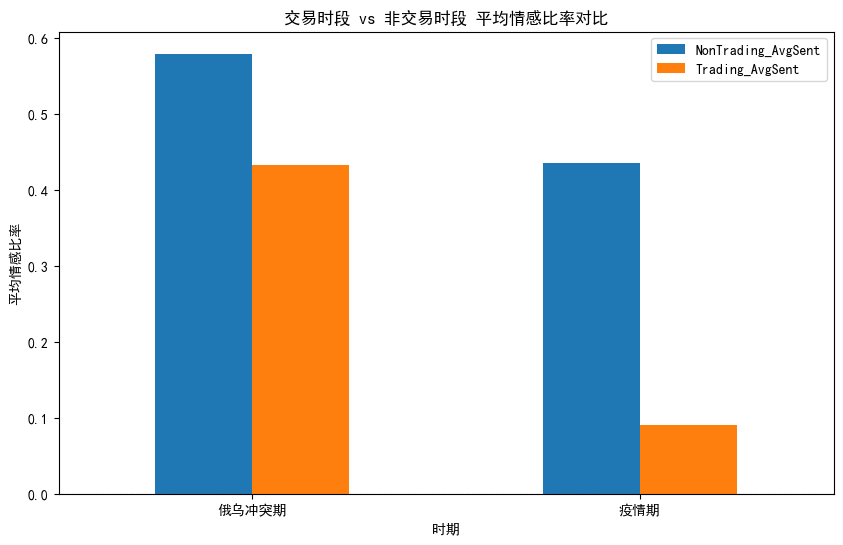

In [34]:
# 可视化对比(柱状图)
avg_sent_by_tradetime.plot(kind='bar', figsize=(10,6))
plt.title('交易时段 vs 非交易时段 平均情感比率对比')
plt.xlabel('时期')
plt.ylabel('平均情感比率')
plt.xticks(rotation=0)
plt.axhline(0,color='grey',linewidth=0.8,linestyle='--') # 添加零线



In [ ]:
# 观察交易日前后情绪变化（更复杂，需要按日期和时间排序处理）
# 例如，可以比较 交易日9:00-15:00的情绪 与 前一天15：00-当天9：00的情绪 差异
# 需要更复杂的情绪处理，例如将日期和时间段合并或排序

# 简化：查看交易时段的帖子/阅读量占比，了解信息发布集中度
volume_by_tradetime = df_comp_trade.groupby(['Period','Tradetime_Dum'])[['Tpostnum','Readnum','Commentnum']].sum()
# 错误情况：使用.apply(lambda)语句计算占比，导致结果在原df上再加一层索引
# volume_by_tradetime_pct =volume_by_tradetime.groupby(level='Period').apply(lambda x:100*x / x.sum())
# volume_by_tradetime_pct.rename(index={0:'非交易时段',1:'交易时段'},inplace=True) # 使用 level='Tradetime_Dum' 可能更好，或直接unstack
#     # .groupby(level='Period') 是一种在Pandas库中用于数据分组的方法。
#     # 它表示按照数据中的'Period'这一层级（通常在多级索引DataFrame中）对数据进行分组。
#     # 这样可以将具有相同'Period'值的数据点归为一组，便于后续进行聚合、转换或分析操作。
#     # 简单来说，就是根据'Period'这一列或索引的不同值，将数据分成若干组。
# print('\n按时期和是否交易时段划分的发帖/阅读/评论量占比(%)')
# print(volume_by_tradetime_pct)


按时期和是否交易时段划分的发帖/阅读/评论量占比(%)
                              Tpostnum    Readnum  Commentnum
Period Period Tradetime_Dum                                  
俄乌冲突期  俄乌冲突期  非交易时段          37.280058  50.092469   52.114909
              交易时段           62.719942  49.907531   47.885091
疫情期    疫情期    非交易时段          33.080537  45.123460   44.900842
              交易时段           66.919463  54.876540   55.099158


In [ ]:
# print(volume_by_tradetime_pct[['Tpostnum','Readnum']].unstack(level='Tradetime_Dum'))

                Tpostnum               Readnum           
Tradetime_Dum       交易时段      非交易时段       交易时段      非交易时段
Period Period                                            
俄乌冲突期  俄乌冲突期   62.719942  37.280058  49.907531  50.092469
疫情期    疫情期     66.919463  33.080537  54.876540  45.123460


In [ ]:
# 正确处理：使用transform() 方法
# groupby(level='Period').transform('sum') 会返回一个与 volume_by_tradetime 形状相同、索引相同的DataFrame,
# 其中每个单元格的值是其所属 Period 分组的总和。
period_sums = volume_by_tradetime.groupby(level='Period').transform('sum')

# 直接用原始总量除以同形状的时期总和，得到占比，索引保持不变 (Period, Tradetime_Dum)
volume_by_tradetime_pct = 100 * volume_by_tradetime / (period_sums + 1e-6) # 加 epsilon 防除零

print("\n按时期和是否交易时段划分的发帖/阅读/评论量占比 (%) [使用 Transform]:")
# 打印前检查一下索引，确认结构是 (Period, Tradetime_Dum)
print(volume_by_tradetime_pct.head())
print("\n索引结构:")
print(volume_by_tradetime_pct.index)


按时期和是否交易时段划分的发帖/阅读/评论量占比 (%) [使用 Transform]:
                       Tpostnum    Readnum  Commentnum
Period Tradetime_Dum                                  
俄乌冲突期  0              37.280058  50.092469   52.114909
       1              62.719942  49.907531   47.885091
疫情期    0              33.080537  45.123460   44.900842
       1              66.919463  54.876540   55.099158

索引结构:
MultiIndex([('俄乌冲突期', 0),
            ('俄乌冲突期', 1),
            (  '疫情期', 0),
            (  '疫情期', 1)],
           names=['Period', 'Tradetime_Dum'])


In [78]:
p=volume_by_tradetime_pct[['Tpostnum','Readnum']].unstack(level='Tradetime_Dum')
p.rename(columns={0:'非交易时段',1:'交易时段'},inplace=True)
print(p)

                Tpostnum               Readnum           
Tradetime_Dum      非交易时段       交易时段      非交易时段       交易时段
Period                                                   
俄乌冲突期          37.280058  62.719942  50.092469  49.907531
疫情期            33.080537  66.919463  45.123460  54.876540


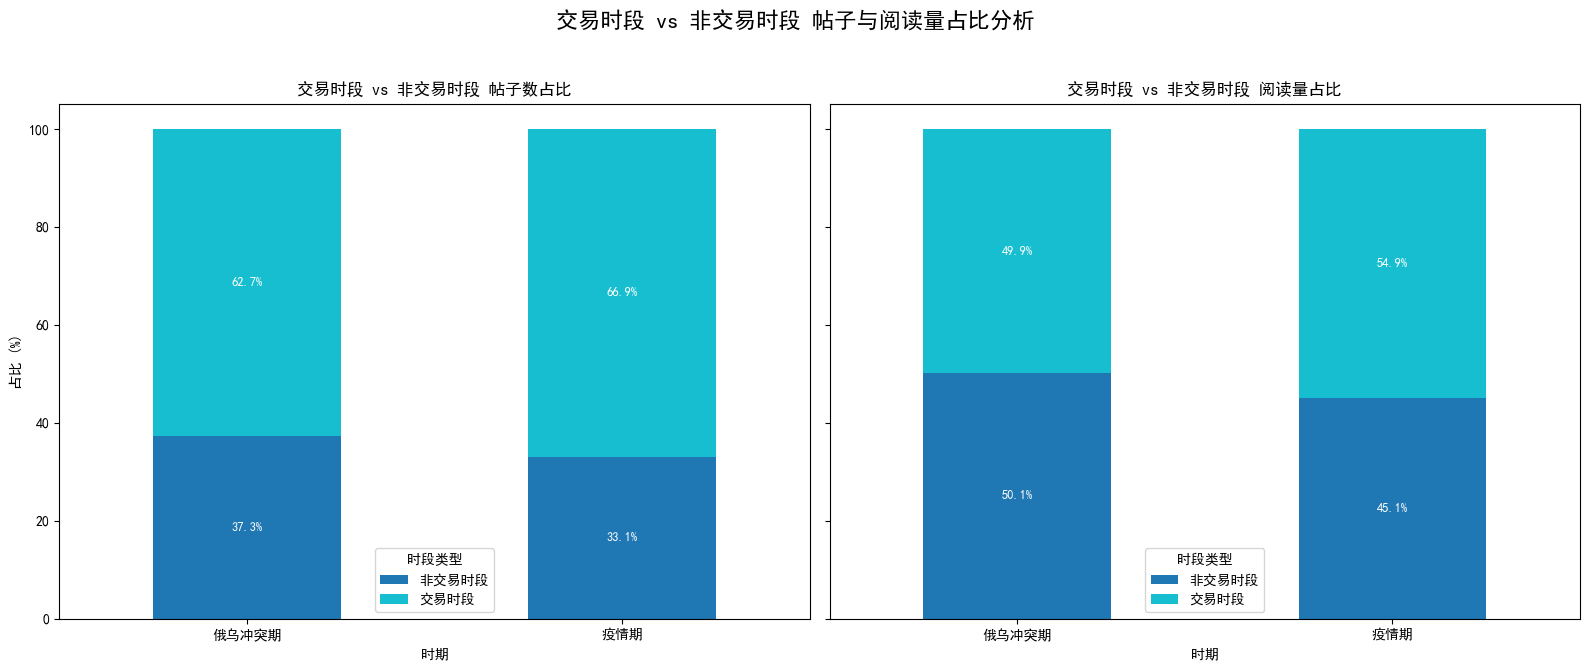

In [85]:
# --- 4. 可视化占比 (这部分代码可以保持不变) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# 绘制帖子数占比图
p['Tpostnum'].plot(kind='bar', stacked=True, ax=axes[0], colormap='tab10')
axes[0].set_title('交易时段 vs 非交易时段 帖子数占比')
axes[0].set_xlabel('时期')
axes[0].set_ylabel('占比 (%)')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='时段类型')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', label_type='center', color='white', weight='bold', fontsize=9)
# 绘制阅读量占比图
p['Readnum'].plot(kind='bar', stacked=True, ax=axes[1], colormap='tab10')
axes[1].set_title('交易时段 vs 非交易时段 阅读量占比')
axes[1].set_xlabel('时期')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='时段类型')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', label_type='center', color='white', weight='bold', fontsize=9)

plt.suptitle('交易时段 vs 非交易时段 帖子与阅读量占比分析', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('tradetime_volume_percentage_subplots_transform.png')
plt.show()

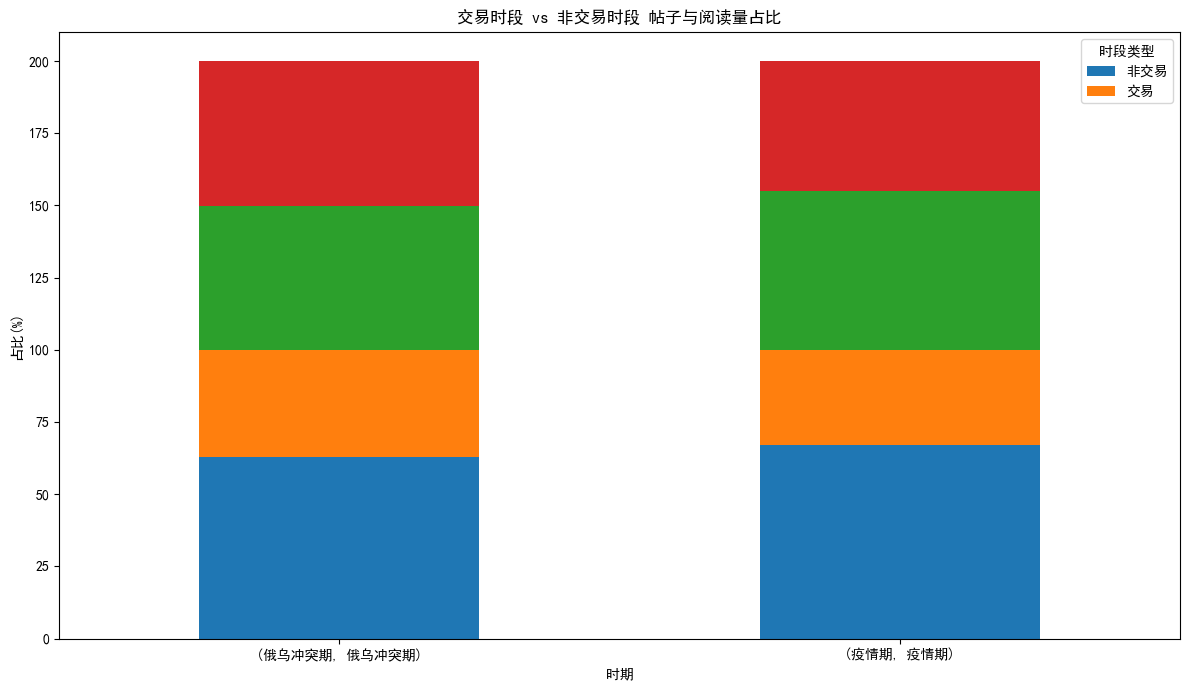

In [ ]:
# 错误：将两个指标公用同一组的可视化占比(堆叠柱状图)
# volume_by_tradetime_pct[['Tpostnum','Readnum']].unstack(level='Tradetime_Dum').plot(kind='bar',stacked=True,figsize=(12,7))
# plt.title('交易时段 vs 非交易时段 帖子与阅读量占比')
# plt.xlabel('时期')
# plt.ylabel('占比(%)')
# plt.xticks(rotation=0)
# plt.legend(title='时段类型',labels=['非交易','交易'])  # 确认标签对应

# plt.tight_layout()
#     # plt.tight_layout() 用于自动调整子图参数，使之填充整个图像区域，同时尽量减少子图之间的重叠。
#     # 当在一个图像中绘制多个子图时，经常会遇到子图之间的间距、标签或标题显示不全的问题，
#     # 使用 plt.tight_layout() 可以有效地解决这些问题，使图像更加整洁和美观。
#     # 简而言之，这个函数的作用是优化图像布局，确保所有元素都能恰当地显示。
# plt.savefig('tradetime_volume_percentage.png')
# plt.show()

## 第6步：关联性分析 (与黄金价格)
- **操作**: 获取同期的黄金价格数据（例如*伦敦金现货价格XAUUSD，或国内黄金期货价格*），与计算出的情感指数进行相关性分析或可视化对比。
- 上海黄金交易所现货实盘 Au99.99 品  种 作 为 黄 金 价 格 代 表 进 行 研 究 ,数 据 来 自 国 泰 安 CSMAR 数 据 库 ,样 本 期 为 2020—2022 年 ,得到1213个日度数据。
- **注释与依据**:
    - **外部数据整合**: 这是将文本情绪分析与实际市场行为联系起来的关键一步。获取可靠、频率匹配（*日度）的黄金价格数据*至关重要。
    - **数据合并**: 使用 `join` 或 `merge` 将价格数据按日期合并到聚合的情感数据中。`how='inner'` 保证只分析两者都有数据的日期。
    - **相关性分析 (`.corr()`)**: 计算**皮尔逊相关系数矩阵**，快速了解哪些情绪/关注度指标与金价呈正相关或负相关。注意：相关性不等于因果性！
    - 热力图 (sns.heatmap): 直观展示相关系数矩阵，颜色深浅和正负表示相关性强弱和方向。
    - 可视化对比: 将情感指数曲线和价格曲线放在同一时间轴上对比，直观观察两者走势是否一致、是否存在*领先/滞后*关系。
    - 格兰杰因果检验 (可选，高级): 引入 `statsmodels` 库进行**格兰杰因果检验**，可以初步探索**一个时间序列是否有助于预测另一个时间序列**。这是比简单相关性更进一步的分析，但结果解释需谨慎，且对*数据平稳性*有要求。在Pre中展示这个方法可以体现统计深度，但要强调其局限性。

In [86]:
print("\n--- 开始关联性分析 (需要外部黄金价格数据) ---")

# --- 1. 加载黄金价格数据 ---
# 假设你找到了一个包含日期和收盘价的CSV文件: gold_price.csv
# 列名可能为 'Date', 'Close_Price'
# try:
    
# 确保日期格式一致，并设为索引
gold_price_df = pd.read_csv('gold_price.csv')
gold_price_df['Date'] = pd.to_datetime(gold_price_df['Date'])
gold_price_df = gold_price_df.set_index('Date')
# 仅保留收盘价，并重命名
gold_price_df = gold_price_df[['Close_Price']].rename(columns={'Close_Price': 'Gold_Price'})
print("黄金价格数据加载成功。")

   


#     else:
#         print("缺少聚合后的公司情感数据 ('daily_agg_comp')，无法进行关联分析。")

# except FileNotFoundError:
#     print("错误：未找到黄金价格数据文件 'gold_price.csv'。请准备该文件。")
# except Exception as e:
#     print(f"处理黄金价格数据或进行关联分析时出错: {e}")


--- 开始关联性分析 (需要外部黄金价格数据) ---
黄金价格数据加载成功。


In [87]:
# --- 2. 合并情感数据与价格数据 ---
    # 以每日聚合的公司数据为例
if 'daily_agg_comp' in locals():
    # 确保 daily_agg_comp 的 Date 是索引或普通列，以便合并
    if not isinstance(daily_agg_comp.index, pd.DatetimeIndex):
        daily_agg_comp = daily_agg_comp.set_index('Date')

    # 使用 merge 或 join 合并
    merged_data = daily_agg_comp.join(gold_price_df, how='inner') # inner join 只保留双方都有的日期
    print("\n已合并情感数据与黄金价格数据。")
    print(merged_data[['Sent_Ratio_overall', 'Sent_Ratio_wavg_Readnum', 'Tpostnum_sum', 'Gold_Price']].head())

        


已合并情感数据与黄金价格数据。
            Sent_Ratio_overall  Sent_Ratio_wavg_Readnum  Tpostnum_sum  \
Date                                                                    
2020-07-01            0.184783                 0.196932           798   
2020-07-02           -0.009174                 0.010942           706   
2020-07-03            0.202952                 0.214601           585   
2020-07-06            0.250996                 0.245910           537   
2020-07-07            0.272265                 0.276071           751   

            Gold_Price  
Date                    
2020-07-01      400.82  
2020-07-02      396.04  
2020-07-03      397.55  
2020-07-06      396.97  
2020-07-07      397.46  



情感/关注度指标与黄金价格的相关系数矩阵:
                         Sent_Ratio_overall  Sent_Ratio_wavg_Readnum  \
Sent_Ratio_overall                 1.000000                 0.996816   
Sent_Ratio_wavg_Readnum            0.996816                 1.000000   
Tpostnum_sum                      -0.290383                -0.291059   
Readnum_sum                       -0.283272                -0.285625   
Commentnum_sum                    -0.037510                -0.037698   
Gold_Price                        -0.482199                -0.485035   

                         Tpostnum_sum  Readnum_sum  Commentnum_sum  Gold_Price  
Sent_Ratio_overall          -0.290383    -0.283272       -0.037510   -0.482199  
Sent_Ratio_wavg_Readnum     -0.291059    -0.285625       -0.037698   -0.485035  
Tpostnum_sum                 1.000000     0.915576        0.888151    0.450801  
Readnum_sum                  0.915576     1.000000        0.878247    0.434926  
Commentnum_sum               0.888151     0.878247        1.000000 

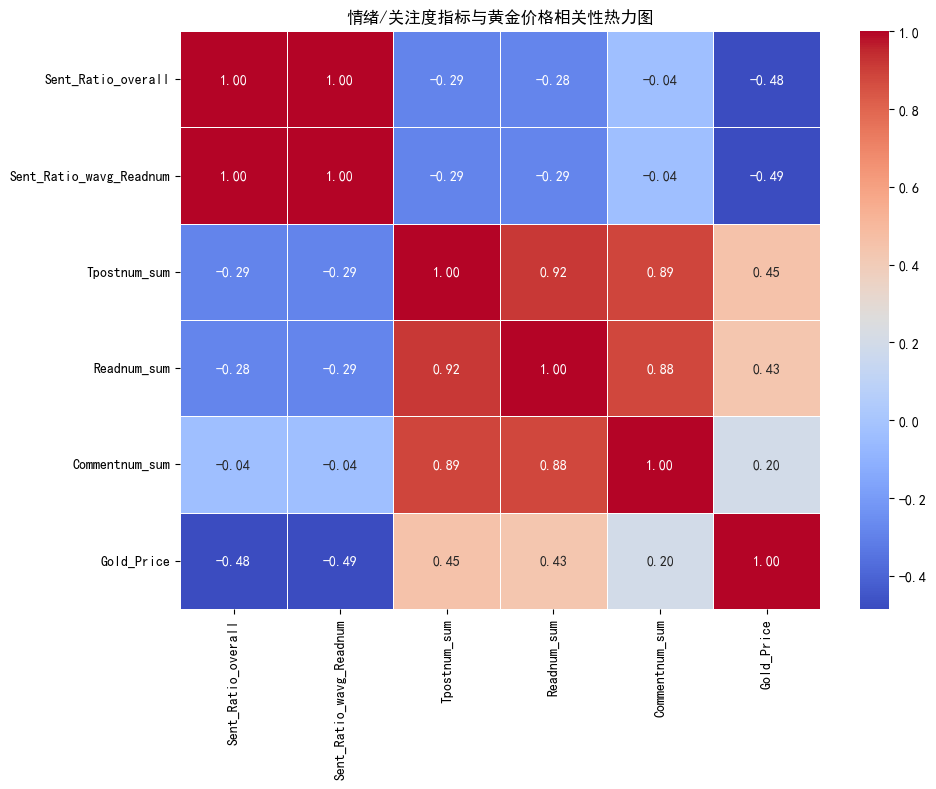

In [88]:
# --- 3. 计算相关系数 ---
# 选择要分析的列
columns_to_correlate = ['Sent_Ratio_overall', 'Sent_Ratio_wavg_Readnum', 'Tpostnum_sum', 'Readnum_sum', 'Commentnum_sum', 'Gold_Price']
correlation_matrix = merged_data[columns_to_correlate].corr()
print("\n情感/关注度指标与黄金价格的相关系数矩阵:")
print(correlation_matrix)

# 可视化相关系数矩阵 (热力图)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('情绪/关注度指标与黄金价格相关性热力图')
plt.tight_layout()
plt.savefig('correlation_heatmap_sentiment_price.png')
plt.show()

       

In [89]:
# --- 4. 可视化对比情感与价格走势 ---
fig_sent_price = make_subplots(rows=2, cols=1, shared_xaxes=True,
                            subplot_titles=("每日聚合情感比率 (Overall)", "黄金价格 (收盘价)"))

fig_sent_price.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Sent_Ratio_overall'], name='Sentiment Ratio'), row=1, col=1)
fig_sent_price.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey", row=1, col=1)

fig_sent_price.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Gold_Price'], name='Gold Price'), row=2, col=1)

fig_sent_price.update_layout(title_text="每日总体情感比率与黄金价格走势对比", height=600)
fig_sent_price.update_yaxes(title_text="情感比率 (-1 to 1)", range=[-1, 1], row=1, col=1)
fig_sent_price.update_yaxes(title_text="黄金价格", row=2, col=1)
fig_sent_price.update_xaxes(title_text="日期", row=2, col=1)
fig_sent_price.show()
# fig_sent_price.write_image("sentiment_vs_gold_price.png")



## 格兰杰因果检验 (Granger Causality)的理论依据
在时间序列分析中,因果关系是指一个时间序列的变化能够对另一个时间序列的变化产生影响。格兰杰因果关系检验由 2003 年诺贝尔经济学奖得主 Granger  所提出,是一种用于检验**两个时间序列之间是否存在因果关系的假设检验统计方法**。其基本思想是,如果在包含 $X$ 和 $Y$ 的过去信息的情况下,对 $Y$ 的预测效果  要优于只单独使用 $Y$ 的过去信息预测 $Y$,即 $X$ 能够有效帮助解释 $Y$ 的未来变化,  那么可以认为 $X$ 是引致 $Y$ 的格兰杰因(Granger-cause)。

In [92]:
# (高级) 考虑格兰杰因果检验 (Granger Causality)
# 查看情绪指标是否能预测价格变化（或反之）
from statsmodels.tsa.stattools import grangercausalitytests
# 需要数据平稳，可能需要差分
data_for_granger = merged_data[['Gold_Price', 'Sent_Ratio_overall']].dropna()
# 差分示例
data_diff = data_for_granger.diff().dropna()
try:
    gc_res = grangercausalitytests(data_diff[['Gold_Price', 'Sent_Ratio_overall']], maxlag=4) # 测试情绪是否格兰杰引起价格
    print("\n格兰杰因果检验 (情绪 -> 价格):")
    # 解析结果比较复杂，通常看p值
    print(gc_res)
except Exception as gc_e:
     print(f"格兰杰因果检验失败: {gc_e}")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0110  , p=0.3162  , df_denom=154, df_num=1
ssr based chi2 test:   chi2=1.0307  , p=0.3100  , df=1
likelihood ratio test: chi2=1.0273  , p=0.3108  , df=1
parameter F test:         F=1.0110  , p=0.3162  , df_denom=154, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5931  , p=0.5539  , df_denom=151, df_num=2
ssr based chi2 test:   chi2=1.2256  , p=0.5418  , df=2
likelihood ratio test: chi2=1.2208  , p=0.5431  , df=2
parameter F test:         F=0.5931  , p=0.5539  , df_denom=151, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0075  , p=0.1154  , df_denom=148, df_num=3
ssr based chi2 test:   chi2=6.3074  , p=0.0976  , df=3
likelihood ratio test: chi2=6.1825  , p=0.1031  , df=3
parameter F test:         F=2.0075  , p=0.1154  , df_denom=148, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5787  , p=0.1831  